In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
fofID = 35
centralID = 32
uniqueID = int(127*1e6+fofID)

In [5]:
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))

In [6]:
# the history of the main 
uniqueC = int(127*1e6+centralID)
streeC = networkx.dfs_tree(trees, str(uniqueC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))

In [7]:
# ok, lets find all the particleIDs that once belong to the subgroup, and the trayectory of the centre, and the subgroup
Idlist, zlist = [], []

galH, cenH = [], [] # here will be stored the positions across time, ok, that sound awesome

for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
    snap, idd = split_unique_id(int(mm))
    snapC, iddC = split_unique_id(int(mmC))
    tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    if snapC==snap:
        pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
    galH.append(pgal)
    cenH.append(pcen)
    if tempOff[0]>= 0 and tempOff[1]>=0:
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
        zt = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        Idlist.extend(list(tempIds))
        zlist.extend([zt]*tempIds.size)
        

Idlist, zlist = np.array(Idlist), np.array(zlist)
Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
zlist = zlist[Idunique]

galH = np.array(galH)
cenH = np.array(cenH)

In [8]:
Idlist.size

5307

In [9]:
# I got the total list of particles that once belong to a give subgroup, lest see where are today and how this looks.
TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
TdayCoord = sim['SnapNumber_127/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()]

In [10]:
IndexToday = np.in1d(TdayTotalIDs, Idlist)
IndexToday_ = np.where(IndexToday)[0]
OldCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexToday_]

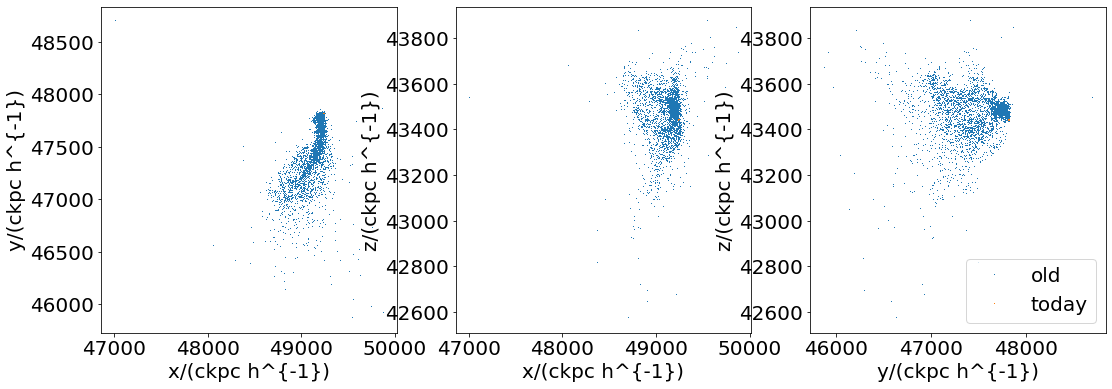

In [11]:
pl.figure(figsize=(18, 6))
mark=','

xt, yt, zt = TdayCoord[:,0], TdayCoord[:,1], TdayCoord[:,2]
xo, yo, zo = OldCoord[:,0], OldCoord[:,1], OldCoord[:,2]

pl.subplot(1, 3, 1)

pl.plot(xo, yo, marker=mark, ls='', label='old')
pl.plot(xt, yt, marker=mark, ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(1, 3, 2)

pl.plot(xo, zo, marker=mark, ls='', label='old')
pl.plot(xt, zt, marker=mark, ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')


pl.subplot(1, 3, 3)

pl.plot(yo, zo, marker=mark, ls='', label='old')
pl.plot(yt, zt, marker=mark, ls='', label='today')

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.legend(loc='best')

In [12]:
# lets remove the ones that are not part of the group today.
TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

IndexNot = np.in1d(Idlist, TdayIDs)
IdNot = Idlist[np.where(IndexNot==False)[0]]

IndexT = np.in1d(TdayTotalIDs, IdNot)
IndexT_ = np.where(IndexT)[0]
LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]
LostCoord.shape, OldCoord.shape

# ok, and the redshift
SurvIds_ = TdayTotalIDs[IndexT_]
iidex = np.in1d(Idlist, SurvIds_)
iidex_ = np.where(iidex)[0]
zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]

is1 = np.argsort(SurvIds_) # the target
is2 = np.argsort(Idlist_) # how things are

zorder = np.zeros(IndexT_.size)
zorder[is1] = zlist_[is2]

In [13]:
# tes if the z-ordering works
#i = 7
#j = np.where(SurvIds_==Idlist[i])[0][0]
#zorder[j], zlist[i]

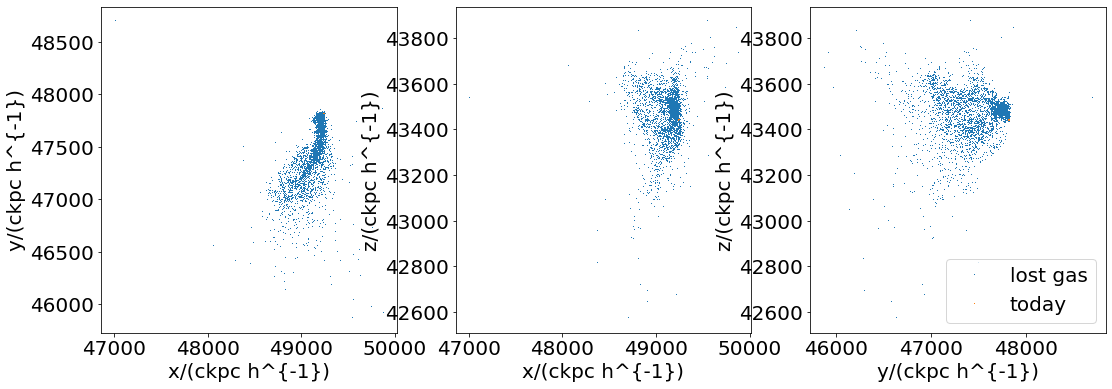

In [14]:
pl.figure(figsize=(18, 6))
mark=','

xt, yt, zt = TdayCoord[:,0], TdayCoord[:,1], TdayCoord[:,2]
xo, yo, zo = LostCoord[:,0], LostCoord[:,1], LostCoord[:,2]

pl.subplot(1, 3, 1)

pl.plot(xo, yo, marker=mark, ls='', label='lost gas')
pl.plot(xt, yt, marker=mark, ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(1, 3, 2)

pl.plot(xo, zo, marker=mark, ls='', label='lost gas')
pl.plot(xt, zt, marker=mark, ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')


pl.subplot(1, 3, 3)

pl.plot(yo, zo, marker=mark, ls='', label='lost gas')
pl.plot(yt, zt, marker=mark, ls='', label='today')

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.legend(loc='best')

In [15]:
#now lets cut at  a certain distance
distance = 600 # distance in ckpc

posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]

dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
distToC = np.sqrt(dx**2+dy**2+dz**2)

icut = np.where(distToC<distance)[0]
IndexT_near = IndexT_[icut] # the index at z=0 of particles that not belong to the galaxy, but are located at least at distance
zorder_near = zorder[icut]

In [16]:
NearCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_near]
LostCoord.shape, NearCoord.shape

((4619, 3), (3669, 3))

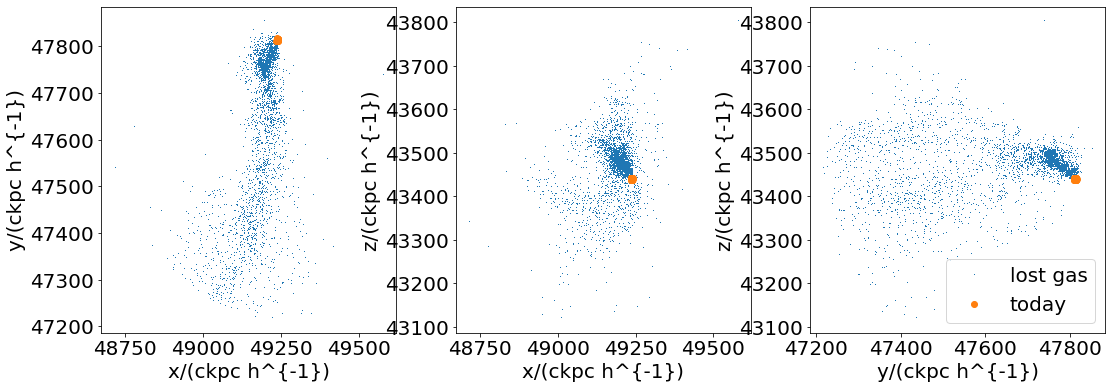

In [17]:
pl.figure(figsize=(18, 6))
mark=','

xt, yt, zt = TdayCoord[:,0], TdayCoord[:,1], TdayCoord[:,2]
xo, yo, zo = NearCoord[:,0], NearCoord[:,1], NearCoord[:,2]

pl.subplot(1, 3, 1)

pl.plot(xo, yo, marker=mark, ls='', label='lost gas')
pl.plot(xt, yt, marker='o', ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(1, 3, 2)

pl.plot(xo, zo, marker=mark, ls='', label='lost gas')
pl.plot(xt, zt, marker='o', ls='', label='today')

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')


pl.subplot(1, 3, 3)

pl.plot(yo, zo, marker=mark, ls='', label='lost gas')
pl.plot(yt, zt, marker='o', ls='', label='today')

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.legend(loc='best')

In [18]:
# ok, lest see velocity and stuff
velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

cenRep = posGal - posCen

velRep = velSat - velCen

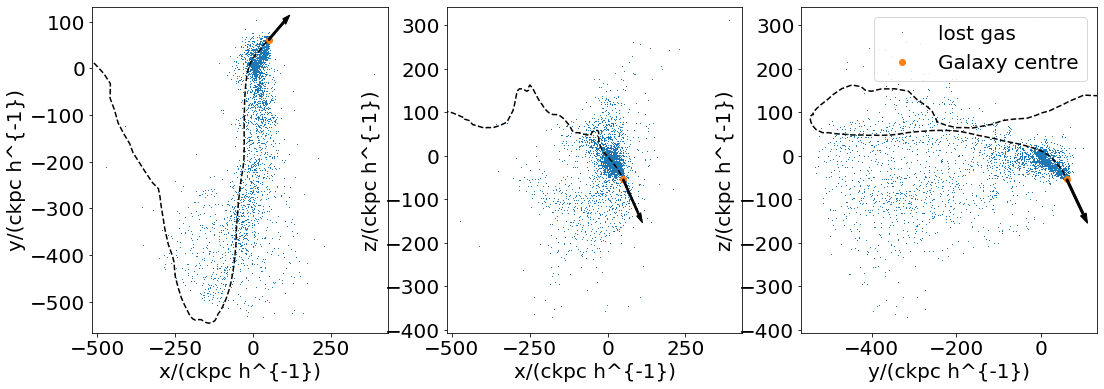

In [19]:
xoC, yoC, zoC = xo - posCen[0], yo - posCen[1], zo - posCen[2]
velX, velY, velZ = velRep[0], velRep[1], velRep[2]

# cenPx, cenPy, cenPz = galH[:,0] - posCen[0], galH[:,1] - posCen[1], galH[:,2] - posCen[2]
cenPx, cenPy, cenPz = galH[:,0] - cenH[:,0], galH[:,1] - cenH[:,1], galH[:,2] - cenH[:,2]

pl.figure(figsize=(18, 6))
mark=','

pl.subplot(1, 3, 1)

pl.plot(xoC, yoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[0], cenRep[1], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[0], cenRep[1], velX, velY, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPx, cenPy, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(1, 3, 2)

pl.plot(xoC, zoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[0], cenRep[2], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[0], cenRep[2], velX, velZ, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPx, cenPz, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')


pl.subplot(1, 3, 3)

pl.plot(yoC, zoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[1], cenRep[2], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[1], cenRep[2], velY, velZ, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPy, cenPz, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.legend(loc='best')

In [20]:
GasMasses = sim['SnapNumber_127/PartType0/Masses'][IndexT_near]
GassAbundances = sim['SnapNumber_127/PartType0/Abundances'][IndexT_near]

print('Lost gas mass\t', np.log10(np.sum(GasMasses)*1e10))

Lost gas mass	 8.850313089603931


In [21]:
elements = ['He', 'C', 'Mg', 'O', 'Fe', 'Si', 'H', 'N', 'Ne', 'S', 'Ca', 'Zi']

for i, el in enumerate(elements):
    Abd = GassAbundances[:,i]
    print('Lost {}:\t'.format(el),np.log10(np.sum(Abd)*1e10))
    
print('Total', np.log10(np.sum(GassAbundances)*1e10), np.log10(np.sum(GasMasses)*1e10))

Lost He:	 8.234771352428812
Lost C:	 5.101690697702824
Lost Mg:	 4.389919377045681
Lost O:	 5.891255754192567
Lost Fe:	 4.961462904971889
Lost Si:	 4.994320563638358
Lost H:	 8.728756735838875
Lost N:	 3.2238075163726907
Lost Ne:	 4.896855585834541
Lost S:	 4.712115603041268
Lost Ca:	 3.8581876697654405
Lost Zi:	 2.6208642618634275
Total 8.850313089603931 8.850313089603931


**let's colour-code particles by redshift**

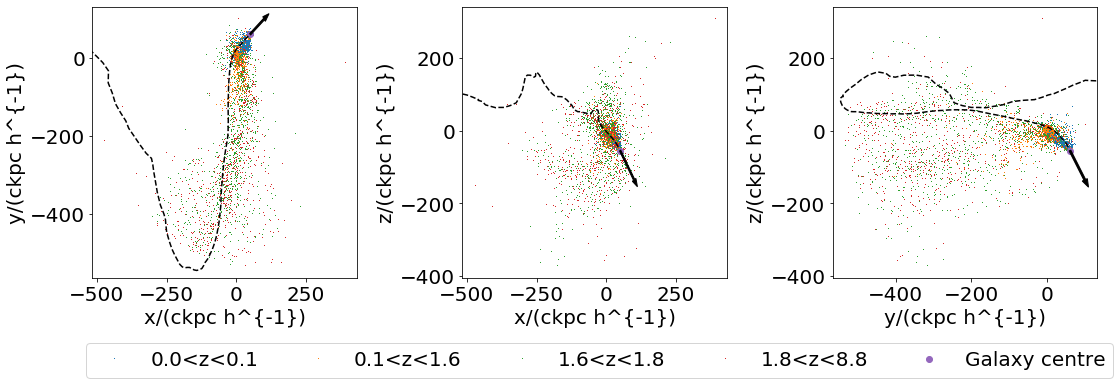

In [22]:
nzbins = 4
# zlim = np.linspace(zorder_near.min(), zorder_near.max(), nzbins+1)
zli = np.percentile(zorder, [25, 50, 75, 100])
zlim = [0.]
zlim.extend(list(zli))
zlim = np.array(zlim)

for i in range(zlim.size):
    zlim[i] = float(int(zlim[i]*10))/10

# zlim = np.array([0, .25, .5, 1.5 , 6])

pl.figure(figsize=(18, 5))
mark=','

pl.subplots_adjust(wspace=.4)

pl.subplot(1, 3, 1)

for zi, zm in zip(zlim[:-1], zlim[1:]):
    i = np.where((zorder_near>zi) & (zorder_near<zm))
    xoCT, yoCT = xoC[i], yoC[i]
    pl.plot(xoCT, yoCT, marker=mark, ls='', label='{}<z<{}'.format(zi, zm))
    
# pl.plot(xoC, yoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[0], cenRep[1], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[0], cenRep[1], velX, velY, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPx, cenPy, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(1, 3, 2)

for zi, zm in zip(zlim[:-1], zlim[1:]):
    i = np.where((zorder_near>zi) & (zorder_near<zm))
    xoCT, zoCT = xoC[i], zoC[i]
    pl.plot(xoCT, zoCT, marker=mark, ls='', label='{}<z<{}'.format(zi, zm))

# pl.plot(xoC, zoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[0], cenRep[2], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[0], cenRep[2], velX, velZ, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPx, cenPz, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')


pl.subplot(1, 3, 3)

for zi, zm in zip(zlim[:-1], zlim[1:]):
    i = np.where((zorder_near>zi) & (zorder_near<zm))
    yoCT, zoCT = yoC[i], zoC[i]
    pl.plot(yoCT, zoCT, marker=mark, ls='', label='{}<z<{}'.format(zi, zm))

# pl.plot(yoC, zoC, marker=mark, ls='', label='lost gas')
pl.plot(cenRep[1], cenRep[2], marker='o', ls='', label='Galaxy centre')
pl.arrow(cenRep[1], cenRep[2], velY, velZ, zorder=20, width=5, color='black')

xl, yl = pl.xlim(), pl.ylim()
pl.plot(cenPy, cenPz, ls='--', color='black')
pl.xlim(xl)
pl.ylim(yl)

pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.legend(loc='best', ncol=zlim.size+1, bbox_to_anchor=[1.1,-0.2])

**now apply some rotations**

In [23]:
# first lets re-define coordinates in a galactocentric scheme.
X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy

In [24]:
# now define normalized vectors, for velocity and centre directions
velX, velY, velZ = velRep[0], velRep[1], velRep[2]
Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
Cen = np.sqrt(xC**2 + yC**2 + zC**2)

velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
xc, yc, zc = xC/Cen, yC/Cen, zC/Cen

In [25]:
# Then, the rotations matrix are, for velocity
I= np.identity(3)

faV = (1-velx)/(vely**2+ velz**2)
VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
VV2 = np.matmul(VV, VV)

RV = I + VV + VV2*faV
RV

array([[ 0.48890683,  0.38147814, -0.78450273],
       [-0.38147814,  0.90226012,  0.20100025],
       [ 0.78450273,  0.20100025,  0.58664671]])

In [26]:
# and for the direction to the centre
faC = (1-xc)/(yc**2+zc**2)
CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
CC2 = np.matmul(CC, CC)

RC = I + CC + CC2*faC
RC

array([[-0.52011889, -0.63833516,  0.56745445],
       [ 0.63833516,  0.15089014,  0.75482474],
       [-0.56745445,  0.75482474,  0.32899097]])

In [27]:
# ok, lets rotate stuff, first the ones that should be one
np.matmul(RV, np.array([velx, vely, velz])), np.matmul(RC, np.array([xc, yc, zc]))

(array([ 1.00000000e+00,  5.55111512e-17, -5.55111512e-17]),
 array([ 1.00000000e+00, -5.55111512e-17,  2.77555756e-17]))

In [28]:
# apparently works, so. lets calculate the rotated coordinates
xRv, yRv, zRv = [], [], []
xRc, yRc, zRc = [], [], []

for x, y, z in zip(X, Y, Z):
    dV = np.matmul(RV, np.array([x, y, z]))
    dC = np.matmul(RC, np.array([x, y, z]))
    
    xRv.append(dV[0])
    yRv.append(dV[1])
    zRv.append(dV[2])
    
    xRc.append(dC[0])
    yRc.append(dC[1])
    zRc.append(dC[2])
    
xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)

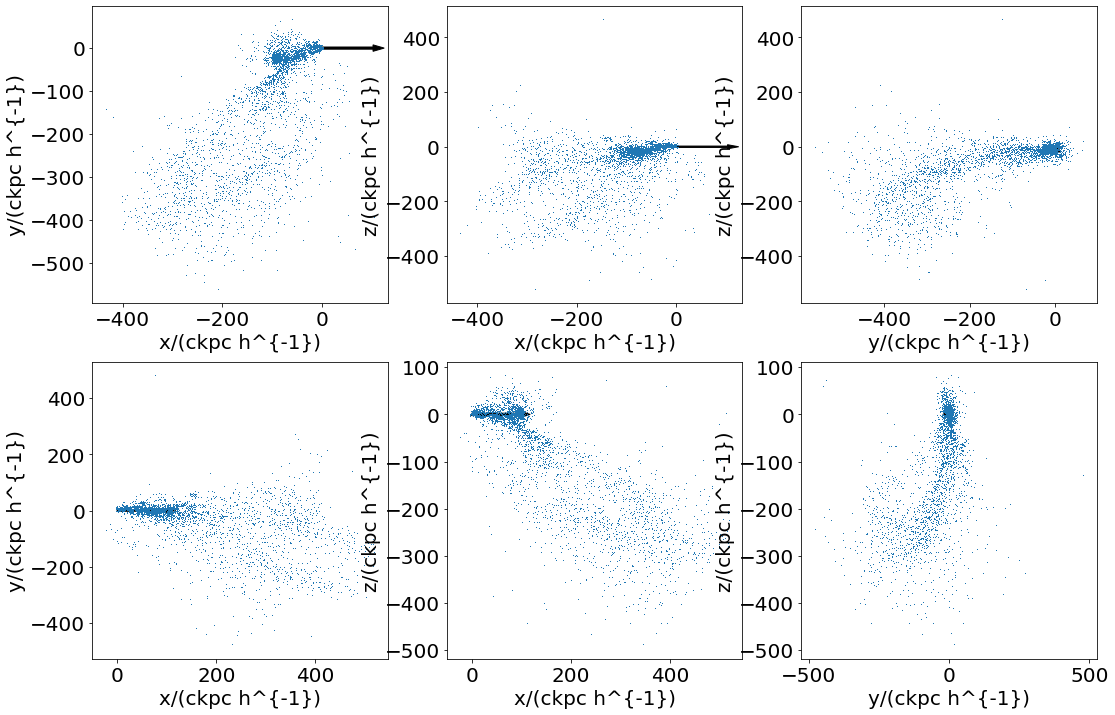

In [29]:
newV = np.matmul(RV, np.array([velX, velY, velZ]))
newC = np.matmul(RC, np.array([xC, yC, zC]))


mark = ','
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

pl.plot(xRv, yRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
pl.arrow(0, 0, newV[0], newV[1], color='black', width=5)

pl.subplot(2, 3, 2)

pl.plot(xRv, zRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
pl.arrow(0, 0, newV[0], newV[2], color='black', width=5)

pl.subplot(2, 3, 3)

pl.plot(yRv, zRv, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
pl.arrow(0, 0, newV[1], newV[2], color='black', width=5)

pl.subplot(2, 3, 4)

pl.plot(xRc, yRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
pl.arrow(0, 0, newC[0], newC[1], color='black', width=5)

pl.subplot(2, 3, 5)

pl.plot(xRc, zRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
pl.arrow(0, 0, newC[0], newC[2], color='black', width=5)

pl.subplot(2, 3, 6)

pl.plot(yRc, zRc, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
pl.arrow(0, 0, newC[1], newC[2], color='black', width=5)

In [30]:
# lest test is distance remains
DD = np.sqrt(X**2+Y**2+Z**2)
DV = np.sqrt(xRv**2+yRv**2+zRv**2)
DC = np.sqrt(xRc**2+yRc**2+zRc**2)

In [31]:
DD, DV, DC

(array([153.43309 , 130.87714 , 132.6856  , ..., 150.72519 , 121.458466,
        120.897316], dtype=float32),
 array([153.43308323, 130.87713505, 132.68558654, ..., 150.72518757,
        121.45846595, 120.89731699]),
 array([153.43308323, 130.87713505, 132.68558654, ..., 150.72518757,
        121.45846595, 120.89731699]))

In [32]:
sim['SnapNumber_128/Header/Redshift/SubGroupPos'][()]

KeyError: 'Unable to open object (message type not found)'

In [ ]:
sim['SnapNumber_128/SubGroups/SubGroupPos']